El presente documento es un breve ejemplo de cómo calcular el beta de mercado de una acción, por medio de una regresión lineal por mínimos cuadrados ordinarios.

Para el ejercicio se va utilizar la acción de *Microsoft* y como estimador de la cartera de mercado se utilizará al *S&P500*. Las librerías necesarias son: *Pandas, Numpy, Datetime, Matplotlib, Pandas Data Reader, Scipy y Dateutil*, las cuales se importan de la siguiente forma:

In [1]:
# libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from pandas_datareader import DataReader as wb
from scipy.stats import linregress
from dateutil.relativedelta import relativedelta

# Obtener datos de mercado desde Yahoo Finance

Los precios de cierre se obtienen desde *Yahoo Finance* utlizando la función *DataReader* de la librería *Pandas Data Reader*. En este caso descargaremos cinco años exactos desde la fecha de hoy, utilizando la función "datetime.now()" de la librería *Datetime* y la función "relativedelta" de la librería *Dateutil*.

los *tickers* de *Microsoft* y del *S&P500* son *MSFT* y *^GSPC* respectivamente. La descarga de datos se hace de la siguiente forma:

In [2]:
# Get market data
start = dt.datetime.now() - relativedelta(years=5)
end = dt.datetime.now()
tickers = {'stock': 'MSFT', 'bench': '^GSPC'}
stock = wb([tickers['stock']],'yahoo',start,end)['Close']
bench = wb([tickers['bench']],'yahoo',start,end)['Close']

Podemos imprimir los *dataframes* resultantes para ver cómo lucen:

In [3]:
print(stock.head(7))
print('---------------')
print(bench.head(7))

Symbols          MSFT
Date                 
2016-10-19  57.529999
2016-10-20  57.250000
2016-10-21  59.660000
2016-10-24  61.000000
2016-10-25  60.990002
2016-10-26  60.630001
2016-10-27  60.099998
---------------
Symbols           ^GSPC
Date                   
2016-10-19  2144.290039
2016-10-20  2141.340088
2016-10-21  2141.159912
2016-10-24  2151.330078
2016-10-25  2143.159912
2016-10-26  2139.429932
2016-10-27  2133.040039


Cabe destacar que la información del *S&P500* no son precios, ya que este al ser un índice lo que descargamos son los puntos. Sin embargo, lo anterior no es un problema porque la regresión lineal es sobre los retornos del activo y de la cartera de mercado, por lo que las variaciones de los puntos diarios del *S&P500* pueden ser considerados (de hecho son) los retornos.

# Sincronizar series de tiempo

Para poder hacer la regresión necesitamos que ambas series de tiempo (la acción y el benchmark) estén sincronizadas, ya que queremos comparar  para cada día los retornos respectivos de la acción y el benchmark. Esto se puede hacer de forma automática con *Pandas Data Reader*, solo basta con importar ambos activos simultaneamente para que la función nos retornne un único *dataframe* con los precios de cierre ya sincronizados. Sin embargo, no siempre se cuanta con la información losta para el análisis, por lo que para poder hacer un ejemplo más realista se descargaron los datos por seraparado, así se puede mostrar como hacer una "limpieza previa".

Para sincronizar ambas series de tiempo se utilizó el siguiente método:

In [4]:
def synsynchronize_returns(df1, df2):
    col = list(df1.columns) + list(df2.columns)
    df1 = df1.pct_change().dropna()
    df2 = df2.pct_change().dropna()
    #Synchronise timetamps
    df1['Date'] = df1.index
    df1 = df1.reset_index(drop=True)
    df2['Date'] = df2.index
    df2 = df2.reset_index(drop=True)
    timestamps_1 = list(df1['Date'].values)
    timestamps_2 = list(df2['Date'].values)
    timetamps = list(set(timestamps_1) & set(timestamps_2))
    #Synchronise timeseries for benchmark
    df1_sync = df1[df1['Date'].isin(timetamps)]
    df1_sync.sort_values(by = 'Date', ascending = True)
    df1_sync = df1_sync.reset_index(drop = True)
    #Synchronise timeseries for asset
    df2_sync = df2[df2['Date'].isin(timetamps)]
    df2_sync.sort_values(by = 'Date', ascending = True)
    df2_sync = df2_sync.reset_index(drop = True)
    #Table for security and benchmark
    df = pd.merge(df1_sync,df2_sync, on='Date')
    df = df[['Date'] + col]
    return df

df = synsynchronize_returns(stock,bench)
print(df.head(7))

Symbols       Date      MSFT     ^GSPC
0       2016-10-20 -0.004867 -0.001376
1       2016-10-21  0.042096 -0.000084
2       2016-10-24  0.022461  0.004750
3       2016-10-25 -0.000164 -0.003798
4       2016-10-26 -0.005903 -0.001740
5       2016-10-27 -0.008742 -0.002987
6       2016-10-28 -0.003827 -0.003108


Sin entrar en mucho detalle, lo que se hizo fue crear una función que recibe como inputs dos *dataframes*, a los cuales se les  calculan los retornos diarios, se les extraen las fechas diarias y se crea una varible llamada "timetamps", esta última es una lista que contine solo las fechas comunes que entre ambos *dataframes*. Posteriormente, se utiliza esta variable (timetamps) para crear dos nuevos dataframes que solo tienen los datos de las fechas comunes. Finalmente, la función retorna la combinanción de estos *dataframe* en un solo.

# Regresión lineal

Para hacer la regresión lineal utilizamos la función "lineregress" de la librería *Scipy*, la cual nos pide una variable independiente "x" y una variable dependiente "y", en este caso los retornos del benchmark serán lo variable independiente y los retornos de la acción serán la variable dependiente. Lo anterior debido a que lo que buscamos ed explicar los retornos de *Microsoft* como una función de los retornos de la cartera de mercado (estimada con el *S6P500*).

Acontinuación se muestra cómo hacer la regresión, cómo se recuperan los factores relevantes y cómo se pueden imprimir en consola los resultados:

In [5]:
# Linear regression
y = df[tickers['stock']].values
x = df[tickers['bench']].values
reg = linregress(x,y)
beta = np.round(reg.slope,3)
alpha = np.round(reg.intercept,3)
r2 = np.round(reg.rvalue**2,3)
pvalue = reg.pvalue
null_hypoth = pvalue > 0.05

In [6]:
# Regresion result
reg_result = 'Linear Regression of ' + str(tickers['stock']) + ' versus ' + str(tickers['bench'] + '\n')\
        + 'Beta:     ' + str(beta) + '\n'\
        + 'Alpha:    ' + str(alpha) + '\n'\
        + 'R^2:      '  + str(r2) + '\n'\
        + 'P-Value:  ' + str(pvalue) + '\n'\
        + 'Null Hypothesis is ' + str(null_hypoth)

print(reg_result)


Linear Regression of MSFT versus ^GSPC
Beta:     1.194
Alpha:    0.001
R^2:      0.694
P-Value:  0.0
Null Hypothesis is False


De lo anterior es relevante destacar dos indicadores. El primero es el *R Cuadrado*, el cual indica cuánto porcentaje de la varianza de los retornos de *Microsoft*, son explicados por los retornos de la cartera de mercado, en este caso es aproximadamente el 70%. El segundo indicador es la *Hipótesis Nula*, la cual se demuestra que es falsa por medio del *P - Value*, lo anterior siginifica que se puede afirmar con un 95% de confianza que el beta de la regresión es distinto a cero, por lo tanto, tiene relevancia estadística.

Por útlimo podemos mostrar visualmente la relación la relación entre la cartera de mercado y la acción de *Microsoft* por medio de un *Scatter* y mostrar además en este gráfico los resultados de la regresión.

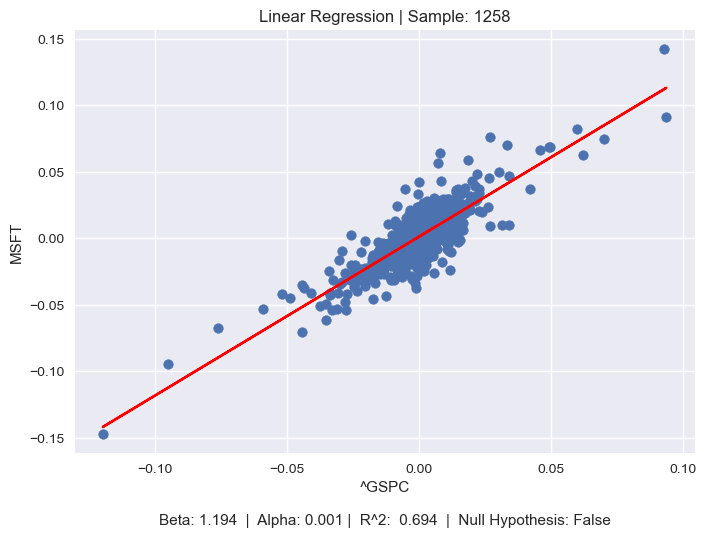

In [8]:
# Plot Regression
predictor = alpha + beta * x
plt.figure()
plt.style.use('seaborn')
plt.title('Linear Regression | Sample: ' + str(len(x)))
plt.scatter(x,y)
plt.ylabel(tickers['stock'])
plt.xlabel(
    tickers['bench'] + '\n' + '\n'\
    + 'Beta: ' + str(beta) + '  |  Alpha: ' + str(alpha)\
    + ' |  R^2:  ' + str(r2) + '  |  Null Hypothesis: ' + str(null_hypoth)
)
plt.plot(x, predictor, color = 'red')
plt.show()
